# Phân cụm các chuyến xe khách dựa trên **giá vé** và **chất lượng dịch vụ**

Các bước thực hiện bài toán *unsupervised learning (clustering)*:
1. Load & kiểm tra dữ liệu
2. Chọn và chuẩn bị feature
3. Scale dữ liệu
4. Huấn luyện KMeans với nhiều số cụm khác nhau
5. Chọn số cụm tối ưu bằng Silhouette Score
6. Trực quan hoá cụm bằng PCA
7. Phân tích & diễn giải từng cụm


## 1. Import thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## 2. Load & kiểm tra dữ liệu

In [2]:
# Đọc tất cả file CSV đã được xử lý trước ở thư mục `../../data/processed`
folder_path = '../../data/processed'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
if not csv_files:
    raise FileNotFoundError('Không tìm thấy file CSV nào trong ../../data/processed')

dfs = []
for f in csv_files:
    tmp = pd.read_csv(f)
    dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True)
print('Data shape:', df.shape)
df.head()

Data shape: (28656, 21)


,company_name,departure_time,pickup_point,arrival_time,dropoff_point,price_original,price_discounted,departure_date,start_point,destination,...,rating_info_accuracy,rating_info_completeness,rating_staff_attitude,rating_comfort,rating_service_quality,rating_punctuality,rating_overall,reviewer_count,number_of_seat,duration_minutes
0,Hoàng Thuỷ,18:45:00,Bến xe,05:45,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,4.7,4.7,4.7,4.6,4.6,4.9,4.7,3485,34,660
1,Sinh Diên Hồng,17:30:00,Bến xe,04:15,Bến xe,370000,296000,2025-11-12,Sài Gòn,Gia Lai,...,4.7,4.8,4.8,4.6,4.6,4.9,4.6,237,34,645
2,Phong Phú,20:00:00,Văn phòng,07:45,Văn phòng,530000,399000,2025-11-12,Sài Gòn,Gia Lai,...,4.5,4.6,4.5,4.4,4.4,4.7,4.5,8677,24,705
3,Kính Diên Hồng,18:40:00,Bến xe,05:40,Bến xe,350000,0,2025-11-12,Sài Gòn,Gia Lai,...,4.6,4.7,4.6,4.5,4.5,4.5,4.6,1135,34,660
4,Đức Đạt,20:10:00,Bến xe,06:35,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,4.5,4.6,4.5,4.5,4.5,4.9,4.7,1027,34,625


In [3]:
# Thông tin tổng quan và thống kê mô tả cho các cột số
display(df.info())
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28656 entries, 0 to 28655
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   company_name              28656 non-null  object 
 1   departure_time            28656 non-null  object 
 2   pickup_point              28656 non-null  object 
 3   arrival_time              28656 non-null  object 
 4   dropoff_point             28656 non-null  object 
 5   price_original            28656 non-null  int64  
 6   price_discounted          28656 non-null  int64  
 7   departure_date            28656 non-null  object 
 8   start_point               28656 non-null  object 
 9   destination               28656 non-null  object 
 10  rating_safety             28656 non-null  float64
 11  rating_info_accuracy      28656 non-null  float64
 12  rating_info_completeness  28656 non-null  float64
 13  rating_staff_attitude     28656 non-null  float64
 14  rating

None

,count,mean,std,min,25%,50%,75%,max
price_original,28656.0,332553.182580,158361.048131,0.0,220000.0,300000.0,405000.0,1200000.0
price_discounted,28656.0,131668.518007,172442.983853,0.0,0.0,0.0,270000.0,900000.0
rating_safety,28656.0,4.586160,0.361528,2.3,4.5,4.7,4.8,5.0
rating_info_accuracy,28656.0,4.451898,0.469673,1.0,4.2,4.6,4.8,5.0
rating_info_completeness,28656.0,4.511554,0.422865,1.0,4.3,4.6,4.8,5.0
rating_staff_attitude,28656.0,4.487720,0.428960,1.0,4.3,4.6,4.8,5.0
rating_comfort,28656.0,4.438264,0.462517,1.0,4.2,4.6,4.7,5.0
rating_service_quality,28656.0,4.404484,0.476747,1.0,4.2,4.5,4.7,5.0
rating_punctuality,28656.0,4.612416,0.466503,1.0,4.6,4.7,4.8,5.0
rating_overall,28656.0,4.427429,0.489651,0.0,4.2,4.6,4.8,5.0


## 3. Chuẩn bị feature cho bài toán phân cụm

Ở bước **EDA / Feature Engineering** trước đó, dữ liệu đã được tạo sẵn một số feature quan trọng:

- `real_price`: giá vé thực tế sau giảm giá
- `price_per_minute`: giá trên mỗi phút di chuyển
- `price_per_seat`: giá trên mỗi ghế
- `service_score`: điểm chất lượng dịch vụ (kết hợp thái độ nhân viên, tiện nghi, chất lượng dịch vụ)
- `trust_score`: điểm độ tin cậy (an toàn, thông tin chính xác, đầy đủ)
- `wilson_score`: điểm đánh giá tổng hợp đã ổn định theo số lượt đánh giá
- `price_rating_ratio_stable`: tỷ số giữa giá và chất lượng (đã chuẩn hoá)

Ở đây ta chỉ **chọn các feature liên quan trực tiếp đến giá và chất lượng** để đưa vào mô hình clustering.

In [4]:
# ================================
# 1. REAL PRICE (giá thực tế)
# ================================
df = df[df["price_original"] != 0].copy()
df["real_price"] = np.where(
    df["price_discounted"] == 0,
    df["price_original"],
    df["price_discounted"]
)


# ================================
# 2. LOG TRANSFORM (giảm skew)
# ================================
df["log_price"] = np.log1p(df["real_price"])


# ================================
# 3. THỜI GIAN & GIÁ THEO PHÚT
# ================================
df['duration_minutes_log'] = np.log1p(df['duration_minutes'])
df["price_per_minute"] = df["real_price"] / df["duration_minutes"]


# ================================
# 4. TỶ LỆ GIẢM GIÁ (đặt lại tên cho đúng)
# ================================
df["discount_rate"] = 1 - df["price_discounted"] / df["price_original"]


# ================================
# 5. SERVICE SCORE
# ================================
service_cols = ["rating_staff_attitude", "rating_service_quality", "rating_comfort"]
df["service_score"] = df[service_cols].mean(axis=1)


# ================================
# 6. TRUST SCORE
# ================================
trust_cols = ["rating_safety", "rating_punctuality", "rating_info_accuracy"]
df["trust_score"] = df[trust_cols].mean(axis=1)


# ================================
# 7. WILSON SCORE
# ================================
def wilson_lower_bound(p, n, z=1.96):
    if n == 0:
        return 0
    denom = 1 + z**2 / n
    centre = p + z*z/(2*n)
    margin = z * np.sqrt((p*(1-p) + z*z/(4*n)) / n)
    return (centre - margin) / denom

df["p"] = df["rating_overall"] / 5
df["wilson_score"] = df.apply(lambda r: wilson_lower_bound(r["p"], r["reviewer_count"]), axis=1)

# optional: xoá p vì chỉ là biến trung gian
df.drop(columns=["p"], inplace=True)


# ================================
# 8. PRICE PER SEAT
# ================================
df["price_per_seat"] = df["real_price"] / df["number_of_seat"]


# ================================
# 9. PRICE–RATING RATIO (ổn định)
# ================================
df["price_rating_ratio_stable"] = df["wilson_score"] / df["log_price"]


# ================================
# 10. FAIRNESS INDEX (giá trị công bằng)
# ================================
df["fairness_index"] = df["wilson_score"] / np.sqrt(df["real_price"])

df['log_price_per_minute'] = np.log1p(df["price_per_minute"])
df['log_price_per_seat'] = np.log1p(df["price_per_seat"])

In [5]:
features = [
    "wilson_score",
    "log_price",
    
    "fairness_index",

    "trust_score",
    "service_score"
]


# Giữ lại các dòng không thiếu dữ liệu ở những cột này
df_cluster = df[features].dropna().copy()


# Xoá các dòng trùng nhau về mặt feature (tránh cụm bị chi phối bởi bản ghi y hệt)
before = df_cluster.shape[0]
df_cluster = df_cluster.drop_duplicates()
after = df_cluster.shape[0]
print(f'Số dòng trước khi drop duplicates: {before}')
print(f'Số dòng sau khi drop duplicates : {after}')
df_cluster.head()

Số dòng trước khi drop duplicates: 28291
Số dòng sau khi drop duplicates : 2600


,wilson_score,log_price,fairness_index,trust_score,service_score
0,0.931620,12.611541,0.001701,4.800000,4.633333
1,0.878389,12.598118,0.001615,4.766667,4.666667
2,0.893510,12.896719,0.001415,4.566667,4.433333
3,0.902763,12.765691,0.001526,4.600000,4.533333
4,0.923770,12.611541,0.001687,4.666667,4.500000


In [6]:
# Kiểm tra phân phối (skewness) của từng biến
df_cluster[features].skew().to_frame('skewness')

,skewness
wilson_score,-1.887607
log_price,-0.131806
fairness_index,0.001631
trust_score,-1.652867
service_score,-1.371546


## 4. Scale dữ liệu (RobustScaler)

Vì một số biến có ngoại lệ (outlier) và phân phối lệch, ta dùng **RobustScaler**:
- Dựa trên median và IQR (Q1–Q3)
- Ít bị ảnh hưởng bởi các giá trị cực trị hơn so với StandardScaler

In [7]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_cluster[features])
X_scaled[:5]

array([[ 0.43291278, -0.06179434,  0.38973509,  0.4       ,  0.35294118],
       [ 0.10795029, -0.0870908 ,  0.2275942 ,  0.33333333,  0.41176471],
       [ 0.20025908,  0.47564225, -0.14774587, -0.06666667,  0.        ],
       [ 0.25674899,  0.22871168,  0.0613714 ,  0.        ,  0.17647059],
       [ 0.38499091, -0.06179434,  0.36283521,  0.13333333,  0.11764706]])

## 5. Tìm số cụm tối ưu (K) bằng Silhouette Score

In [8]:
range_n_clusters = range(2, 9)
silhouette_scores = []

for k in range_n_clusters:
    model = KMeans(n_clusters=k, random_state=40, n_init=10)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f'K={k}, Silhouette Score={score:.4f}')

best_k = range_n_clusters[int(np.argmax(silhouette_scores))]
print('\nSố cụm tốt nhất theo Silhouette:', best_k)

K=2, Silhouette Score=0.4677
K=3, Silhouette Score=0.3215
K=4, Silhouette Score=0.3278
K=5, Silhouette Score=0.3294
K=6, Silhouette Score=0.3071
K=7, Silhouette Score=0.3221
K=8, Silhouette Score=0.3234

Số cụm tốt nhất theo Silhouette: 2


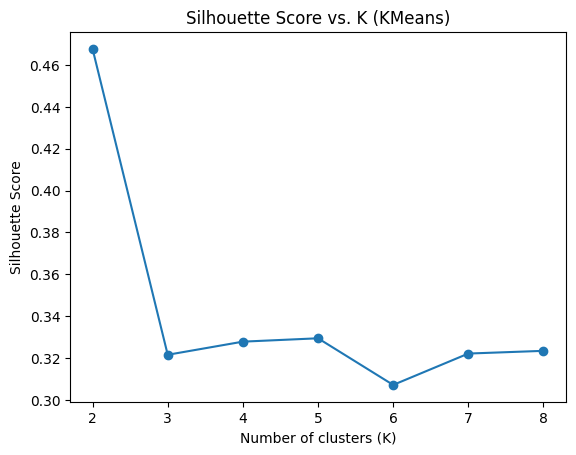

In [9]:
# Vẽ Silhouette Score theo K để trực quan hoá
plt.figure()
plt.plot(list(range_n_clusters), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. K (KMeans)')
plt.show()

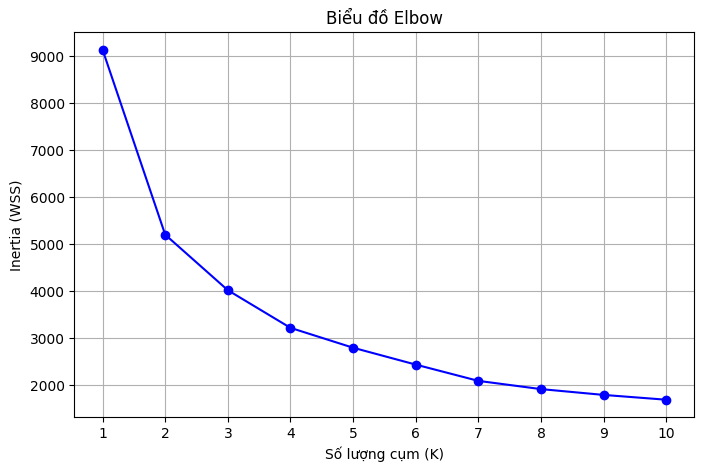

In [10]:
# Vẽ biểu đồ Elbow
wss = [] # WSS: Within-Cluster Sum of Square (Inertia)
k_range = range(1, 11) # Thử nghiệm từ 1 đến 10 cụm

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled) 
    wss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, wss, marker='o', linestyle='-', color='b')
plt.title('Biểu đồ Elbow')
plt.xlabel('Số lượng cụm (K)')
plt.ylabel('Inertia (WSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

+ Từ K=1 xuống K=2: Độ dốc giảm cực mạnh (Inertia giảm từ >6000 xuống ~3500).

+ Từ K=2 xuống K=3: Độ dốc vẫn còn khá lớn (Inertia giảm từ ~3500 xuống ~2800).

+ Từ K=3 trở đi: Đường biểu đồ bắt đầu thoải dần và đi ngang.

Kết luận từ Elbow: Điểm gập khúc (khuỷu tay) nằm ở khoảng K=3.

## 6. Huấn luyện mô hình KMeans với K tối ưu

In [11]:
k_final = 3  # thường là 2 trong dữ liệu hiện tại
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df_cluster = df_cluster.copy()
df_cluster['cluster'] = cluster_labels

print('Silhouette Score (final model):', silhouette_score(X_scaled, cluster_labels))
df_cluster['cluster'].value_counts().sort_index()

Silhouette Score (final model): 0.3180624814153315


cluster
0     737
1     582
2    1281
Name: count, dtype: int64

## 7. Trực quan hoá các cụm bằng PCA (2 chiều)

Explained variance ratio (2 components): 0.880854165317441


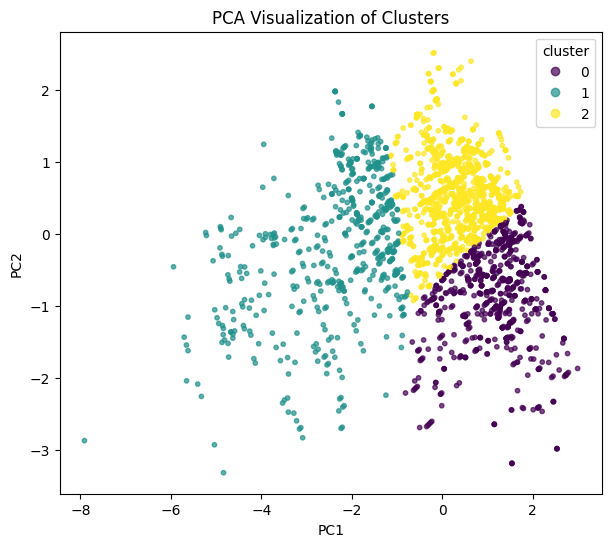

In [12]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print('Explained variance ratio (2 components):', pca.explained_variance_ratio_.sum())

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=10, alpha=0.7)
plt.title('PCA Visualization of Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(*scatter.legend_elements(), title='cluster')
plt.show()

## 8. Phân tích & đặt tên cụm

In [13]:
# Thống kê trung bình các feature theo từng cụm
cluster_summary = df_cluster.groupby('cluster')[features].mean().round(2)
display(cluster_summary)

# Thêm một số thống kê khác nếu cần
cluster_counts = df_cluster['cluster'].value_counts().sort_index()
print('\nSố lượng chuyến xe trong từng cụm:')
display(cluster_counts.to_frame('count'))

,wilson_score,log_price,fairness_index,trust_score,service_score
cluster,,,,,
0,0.86,12.15,0.0,4.62,4.52
1,0.59,12.95,0.0,3.98,3.77
2,0.87,12.81,0.0,4.64,4.53



Số lượng chuyến xe trong từng cụm:


,count
cluster,
0,737
1,582
2,1281


Dựa trên các chỉ số trung bình về **Giá (Log Price)** và **Chất lượng (Trust Score, Service Score, Wilson Score)**, mô hình phân cụm với **K=3** đã phân tách dữ liệu thành 3 phân khúc thị trường rất rõ ràng.

#### 1. Cụm 0: Phân khúc "Ngon - Bổ - Rẻ"
* **Đặc điểm:**
    * **Giá vé:** Thấp nhất trong 3 nhóm.
    * **Chất lượng:** Rất tốt, ngang ngửa với nhóm cao cấp.
    * **Độ tin cậy:** Điểm Wilson cao, cho thấy lượng đánh giá tích cực ổn định.
* **Ý nghĩa:** Đây là nhóm đại diện cho sự "Tối ưu hóa giá trị". Các nhà xe trong nhóm này đã thành công trong việc cung cấp dịch vụ chất lượng cao với chi phí vận hành cạnh tranh. Đây là nhóm chủ lực để thu hút và giữ chân khách hàng trung thành.

#### 3. Cụm 1: Phân khúc "Giá ảo - Chất lượng thấp"
* **Đặc điểm:**
    * **Giá vé:** **Cao nhất** đắt hơn cả nhóm Cao cấp.
    * **Chất lượng:** **Tệ nhất**.
    * **Độ tin cậy:** Thấp nhất.
* **Ý nghĩa:** Nhóm chuyến xe có hiệu suất kém, giá không tương xứng với chất lượng (có thể do độc quyền tuyến, tăng giá mùa cao điểm nhưng phục vụ kém).

#### 2. Cụm 2: Phân khúc "Cao cấp - Đáng tiền"
* **Đặc điểm:**
    * **Giá vé:** Cao.
    * **Chất lượng:** **Tốt nhất thị trường**.
    * **Số lượng:** Chiếm số lượng lớn nhất trong dữ liệu.
* **Ý nghĩa:** Nhóm "tiền nào của nấy". Khách hàng trả giá cao để nhận lại dịch vụ 5 sao.